# Compile GRF Fork from Scratch

In [ ]:
! sudo apt-get update
! sudo apt-get install git cmake build-essential libgl1-mesa-dev libsdl2-dev \
libsdl2-image-dev libsdl2-ttf-dev libsdl2-gfx-dev libboost-all-dev \
libdirectfb-dev libst-dev mesa-utils xvfb x11vnc libsdl-sge-dev python3-pip

In [ ]:
! git clone -b v2.5 https://github.com/mnaylor5/football.git
! cd football && pip3 install .

Download and install worked - onto exploring the environment

In [ ]:
import gfootball.env as football_env
import matplotlib.pyplot as plt
import torch
from torch import nn
from collections import deque
import random
from tqdm.notebook import tqdm_notebook
import copy

Basic example to make sure things work as expected

In [ ]:
env = football_env.create_environment(env_name="11_vs_11_stochastic", 
                                      stacked=False, 
                                      logdir='/tmp/football', 
                                      write_goal_dumps=False, 
                                      write_full_episode_dumps=False, 
                                      render=False)
rewards = []
env.reset()
steps = 0
while True:
  obs, rew, done, info = env.step(env.action_space.sample())
  rewards.append(rew)
  steps += 1
  if steps % 300 == 0:
    print("Step %d Reward: %f" % (steps, rew))
  if done:
    break

print("Steps: %d Reward: %.2f" % (steps, rew))

Step 300 Reward: 0.000000
Step 600 Reward: 0.000000
Step 900 Reward: 0.000000
Step 1200 Reward: 0.000000
Step 1500 Reward: 0.000000
Step 1800 Reward: 0.000000
Step 2100 Reward: 0.000000
Step 2400 Reward: 0.000000
Step 2700 Reward: 0.000000
Step 3000 Reward: 0.000000
Steps: 3001 Reward: 0.00


In [ ]:
sum(rewards)

-3.0

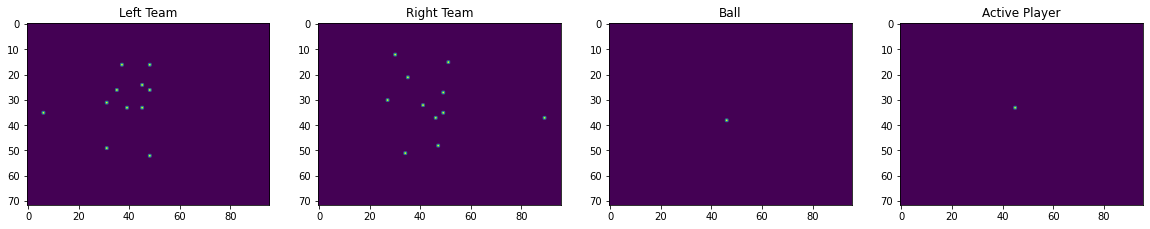

In [ ]:
fig = plt.figure(figsize=(20,8))
channel_names = ("Left Team", "Right Team", "Ball", "Active Player")
for channel, name in enumerate(channel_names):
  ax = fig.add_subplot(1, 4, channel+1)
  ax.imshow(obs[:, :, channel])
  ax.set_title(name)

plt.show()

Make a very simple agent to handle the very simple empty goal scenario. 
* Model: $\epsilon$-greedy DQN with experience replay and a target network, from DRL in Action, Chapter 3
* Observations: `simple115` 
* Scenario: `academy_empty_goal_close`
  * Tested also with `academy_empty_goal`, `academy_pass_and_shoot_with_keeper`, and `academy_counterattack_easy`

This actually works quite well -- using a replay buffer of ~150 steps, this gets the losses down to the 1e-7 range pretty consistently, and with under 10k update steps

The `academy_single_goal_versus_lazy` scenario was definitely more difficult, as there is no memory, and not much detail. However, it still reached 1e-6 - 1e-7 at its best, and parameters like $\epsilon$ and $\gamma$ could be tuned.

In [ ]:
scenario = 'academy_single_goal_versus_lazy'

env = football_env.create_environment(env_name=scenario, 
                                      stacked=False, 
                                      logdir='/tmp/football', 
                                      representation='simple115',
                                      write_goal_dumps=False, 
                                      write_full_episode_dumps=False, 
                                      render=False)

In [ ]:
n_actions = env.action_space.n
obs_shape = env.observation_space.shape[0]

model = nn.Sequential(
  nn.Linear(obs_shape, 64),
  nn.LeakyReLU(),
  nn.Linear(64, 64),
  nn.LeakyReLU(),
  nn.Linear(64, n_actions)
)

loss_fn = nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
model2 = copy.deepcopy(model)
model2.load_state_dict(model.state_dict())
sync_freq = 50 # iter 

In [ ]:
epochs = 60
losses = []
mem_size = 150
batch_size = 32
replay = deque(maxlen=mem_size)
h = 0
j = 0
epsilon = 0.1
gamma = 0.9

for i in tqdm_notebook(range(epochs), "Epoch"):
  env.reset()
  obs, rew, done, info = env.step(1) # no action at first
  obs = torch.from_numpy(obs)
  while not done:
    j += 1
    qval = model(obs)
    if random.random() < epsilon:
      action_ = env.action_space.sample()
    else:
      action_ = qval.argmax().item()
    
    if done:
      break

    # make the move
    obs2, rew2, done2, info2 = env.step(action_)
    obs2 = torch.from_numpy(obs2)
    exp = (obs, action_, rew, obs2, done)
    replay.append(exp)
    obs = obs2
    rew = rew2
    done = done2

    if len(replay) > batch_size:
      minibatch = random.sample(replay, batch_size)
      state1_batch = torch.cat([s1.unsqueeze(0) for s1, a, r, s2, d in minibatch])
      action_batch = torch.Tensor([a for s1, a, r, s2, d in minibatch])
      reward_batch = torch.Tensor([r for s1, a, r, s2, d in minibatch])
      state2_batch = torch.cat([s2.unsqueeze(0) for s1, a, r, s2, d in minibatch])
      done_batch = torch.Tensor([d for s1, a, r, s2, d in minibatch])

      Q1 = model(state1_batch)
      with torch.no_grad():
        Q2 = model2(state2_batch)
      Y = reward_batch + gamma * ((1 - done_batch)) * torch.max(Q2, dim=1)[0]
      X = Q1.gather(dim=1, index=action_batch.long().unsqueeze(1)).squeeze()
      loss = loss_fn(X, Y.detach())
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      losses.append(loss.item())

      if j % sync_freq == 0:
        model2.load_state_dict(model.state_dict())



In [ ]:
print(f"Finished {j+1} moves over {i+1} epochs.")

Finished 12054 moves over 60 epochs.


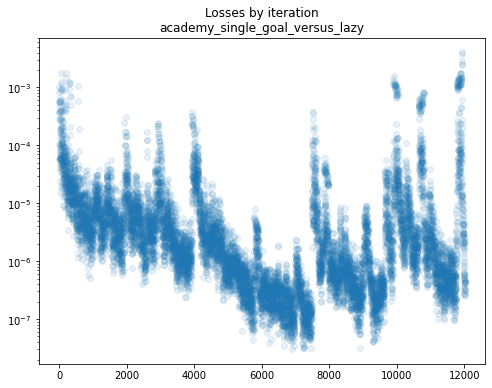

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(range(len(losses)), losses, alpha=0.1)
plt.title(f"Losses by iteration\n{scenario}")
plt.yscale('log')
plt.show()